We'll import all the necessary modules and packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dropout

We'll load the data from the CSV file as a pandas dataframe and then perform the necessary preprocessing operations such as checking for NAN values, formatting the dataframe for input to LSTM etc.

In [2]:
df = pd.read_csv("prices.csv")
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
df.tail()

,date,symbol,open,close,low,high,volume
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
851263,2016-12-30 00:00:00,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [5]:
df.isnull().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [6]:
df.nunique()

date        3524
symbol       501
open       72707
close      73628
low        72900
high       73299
volume    171073
dtype: int64

In [7]:
# converting the date column from object to datetime, later on this will be the index for the dataframe.
df['date'] = pd.to_datetime(df.date)


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    851264 non-null  datetime64[ns]
 1   symbol  851264 non-null  object        
 2   open    851264 non-null  float64       
 3   close   851264 non-null  float64       
 4   low     851264 non-null  float64       
 5   high    851264 non-null  float64       
 6   volume  851264 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 45.5+ MB


In [9]:
df.tail()

,date,symbol,open,close,low,high,volume
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
851263,2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [10]:
# grouping the data for each stock . 
grouped = df.groupby("symbol")


In [11]:
# getting the data for the stock we are going to use for analysis.
ABC_df = grouped.get_group("ABC")

In [12]:
ABC_df.head()

,date,symbol,open,close,low,high,volume
255,2010-01-04,ABC,26.290001,26.629999,26.139999,26.690001,2455900.0
722,2010-01-05,ABC,26.650000,26.440001,26.379999,26.650000,2476800.0
1190,2010-01-06,ABC,26.389999,26.190001,26.080000,26.430000,4039300.0
1658,2010-01-07,ABC,25.770000,25.770000,25.660000,26.160000,5244600.0
2126,2010-01-08,ABC,25.860001,26.049999,25.680000,26.100000,4277500.0


In [13]:
# setting the date as index
ABC_df = ABC_df.set_index('date')

In [14]:
# getting rid of the unuseful column of stock ticker
ABC_df = ABC_df.drop('symbol', axis=1)

In [15]:
ABC_df

,open,close,low,high,volume
date,,,,,
2010-01-04,26.290001,26.629999,26.139999,26.690001,2455900.0
2010-01-05,26.650000,26.440001,26.379999,26.650000,2476800.0
2010-01-06,26.389999,26.190001,26.080000,26.430000,4039300.0
2010-01-07,25.770000,25.770000,25.660000,26.160000,5244600.0
2010-01-08,25.860001,26.049999,25.680000,26.100000,4277500.0
...,...,...,...,...,...
2016-12-23,78.040001,78.559998,77.889999,78.930000,575300.0
2016-12-27,78.419998,78.820000,78.300003,79.269997,648700.0
2016-12-28,78.860001,78.349998,78.209999,79.220001,842500.0


In [16]:
import ta 
ABC_df['RSI'] = ta.momentum.RSIIndicator(ABC_df['close'],fillna = True).rsi()

In [17]:
ABC_df.head(20)

,open,close,low,high,volume,RSI
date,,,,,,
2010-01-04,26.290001,26.629999,26.139999,26.690001,2455900.0,100.000000
2010-01-05,26.650000,26.440001,26.379999,26.650000,2476800.0,0.000000
2010-01-06,26.389999,26.190001,26.080000,26.430000,4039300.0,0.000000
2010-01-07,25.770000,25.770000,25.660000,26.160000,5244600.0,0.000000
2010-01-08,25.860001,26.049999,25.680000,26.100000,4277500.0,26.983065
2010-01-11,26.240000,26.340000,26.110001,26.480000,1914400.0,43.874878
2010-01-12,26.320000,26.520000,26.190001,26.549999,3142600.0,51.391499
2010-01-13,26.590000,27.040001,26.590000,27.129999,3150100.0,65.687952
2010-01-14,26.969999,27.209999,26.850000,27.250000,2054300.0,68.907507


In [18]:
ABC_df['WilliamsR'] = ta.momentum.WilliamsRIndicator(ABC_df['high'],ABC_df['low'],ABC_df['close'], fillna = True).wr()

In [19]:
ABC_df

,open,close,low,high,volume,RSI,WilliamsR
date,,,,,,,
2010-01-04,26.290001,26.629999,26.139999,26.690001,2455900.0,100.000000,-10.909415
2010-01-05,26.650000,26.440001,26.379999,26.650000,2476800.0,0.000000,-45.454380
2010-01-06,26.389999,26.190001,26.080000,26.430000,4039300.0,0.000000,-81.967079
2010-01-07,25.770000,25.770000,25.660000,26.160000,5244600.0,0.000000,-89.320399
2010-01-08,25.860001,26.049999,25.680000,26.100000,4277500.0,26.983065,-62.136056
...,...,...,...,...,...,...,...
2016-12-23,78.040001,78.559998,77.889999,78.930000,575300.0,51.575545,-24.679499
2016-12-27,78.419998,78.820000,78.300003,79.269997,648700.0,52.468278,-19.999977
2016-12-28,78.860001,78.349998,78.209999,79.220001,842500.0,50.650470,-37.173921


In [20]:
ABC_df['SMA'] = ta.trend.sma_indicator(ABC_df['close'], fillna = True)

In [21]:
ABC_df

,open,close,low,high,volume,RSI,WilliamsR,SMA
date,,,,,,,,
2010-01-04,26.290001,26.629999,26.139999,26.690001,2455900.0,100.000000,-10.909415,26.629999
2010-01-05,26.650000,26.440001,26.379999,26.650000,2476800.0,0.000000,-45.454380,26.535000
2010-01-06,26.389999,26.190001,26.080000,26.430000,4039300.0,0.000000,-81.967079,26.420000
2010-01-07,25.770000,25.770000,25.660000,26.160000,5244600.0,0.000000,-89.320399,26.257500
2010-01-08,25.860001,26.049999,25.680000,26.100000,4277500.0,26.983065,-62.136056,26.216000
...,...,...,...,...,...,...,...,...
2016-12-23,78.040001,78.559998,77.889999,78.930000,575300.0,51.575545,-24.679499,78.077499
2016-12-27,78.419998,78.820000,78.300003,79.269997,648700.0,52.468278,-19.999977,78.239166
2016-12-28,78.860001,78.349998,78.209999,79.220001,842500.0,50.650470,-37.173921,78.193333


In [22]:
ABC_df['EMA'] = ta.trend.ema_indicator(ABC_df['close'], fillna=True)

In [23]:
ABC_df

,open,close,low,high,volume,RSI,WilliamsR,SMA,EMA
date,,,,,,,,,
2010-01-04,26.290001,26.629999,26.139999,26.690001,2455900.0,100.000000,-10.909415,26.629999,26.629999
2010-01-05,26.650000,26.440001,26.379999,26.650000,2476800.0,0.000000,-45.454380,26.535000,26.600769
2010-01-06,26.389999,26.190001,26.080000,26.430000,4039300.0,0.000000,-81.967079,26.420000,26.537574
2010-01-07,25.770000,25.770000,25.660000,26.160000,5244600.0,0.000000,-89.320399,26.257500,26.419485
2010-01-08,25.860001,26.049999,25.680000,26.100000,4277500.0,26.983065,-62.136056,26.216000,26.362641
...,...,...,...,...,...,...,...,...,...
2016-12-23,78.040001,78.559998,77.889999,78.930000,575300.0,51.575545,-24.679499,78.077499,78.212849
2016-12-27,78.419998,78.820000,78.300003,79.269997,648700.0,52.468278,-19.999977,78.239166,78.306257
2016-12-28,78.860001,78.349998,78.209999,79.220001,842500.0,50.650470,-37.173921,78.193333,78.312986


In [24]:
ABC_df['CCI'] = ta.trend.CCIIndicator(ABC_df['high'],ABC_df['low'],ABC_df['close'], fillna = True).cci()

In [25]:
ABC_df

,open,close,low,high,volume,RSI,WilliamsR,SMA,EMA,CCI
date,,,,,,,,,,
2010-01-04,26.290001,26.629999,26.139999,26.690001,2455900.0,100.000000,-10.909415,26.629999,26.629999,0.000000
2010-01-05,26.650000,26.440001,26.379999,26.650000,2476800.0,0.000000,-45.454380,26.535000,26.600769,66.666667
2010-01-06,26.389999,26.190001,26.080000,26.430000,4039300.0,0.000000,-81.967079,26.420000,26.537574,-100.000000
2010-01-07,25.770000,25.770000,25.660000,26.160000,5244600.0,0.000000,-89.320399,26.257500,26.419485,-122.727366
2010-01-08,25.860001,26.049999,25.680000,26.100000,4277500.0,26.983065,-62.136056,26.216000,26.362641,-72.222272
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,78.040001,78.559998,77.889999,78.930000,575300.0,51.575545,-24.679499,78.077499,78.212849,32.078166
2016-12-27,78.419998,78.820000,78.300003,79.269997,648700.0,52.468278,-19.999977,78.239166,78.306257,65.006562
2016-12-28,78.860001,78.349998,78.209999,79.220001,842500.0,50.650470,-37.173921,78.193333,78.312986,41.978743


In [26]:
ABC_df['MACD'] = ta.trend.MACD(ABC_df['close'], fillna = True).macd()

In [27]:
ABC_df

,open,close,low,high,volume,RSI,WilliamsR,SMA,EMA,CCI,MACD
date,,,,,,,,,,,
2010-01-04,26.290001,26.629999,26.139999,26.690001,2455900.0,100.000000,-10.909415,26.629999,26.629999,0.000000,0.000000
2010-01-05,26.650000,26.440001,26.379999,26.650000,2476800.0,0.000000,-45.454380,26.535000,26.600769,66.666667,-0.015157
2010-01-06,26.389999,26.190001,26.080000,26.430000,4039300.0,0.000000,-81.967079,26.420000,26.537574,-100.000000,-0.046802
2010-01-07,25.770000,25.770000,25.660000,26.160000,5244600.0,0.000000,-89.320399,26.257500,26.419485,-122.727366,-0.104566
2010-01-08,25.860001,26.049999,25.680000,26.100000,4277500.0,26.983065,-62.136056,26.216000,26.362641,-72.222272,-0.126295
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,78.040001,78.559998,77.889999,78.930000,575300.0,51.575545,-24.679499,78.077499,78.212849,32.078166,0.093133
2016-12-27,78.419998,78.820000,78.300003,79.269997,648700.0,52.468278,-19.999977,78.239166,78.306257,65.006562,0.134668
2016-12-28,78.860001,78.349998,78.209999,79.220001,842500.0,50.650470,-37.173921,78.193333,78.312986,41.978743,0.128182


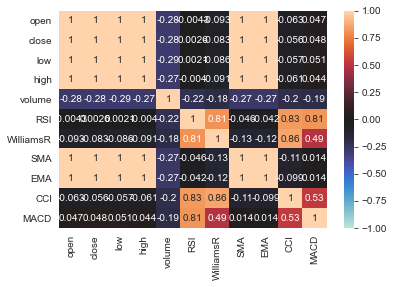

In [28]:
sns.heatmap(ABC_df.corr(), annot = True, vmin=-1, vmax=1, center= 0,)

In [29]:
ABC_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1762 non-null   float64
 1   close      1762 non-null   float64
 2   low        1762 non-null   float64
 3   high       1762 non-null   float64
 4   volume     1762 non-null   float64
 5   RSI        1762 non-null   float64
 6   WilliamsR  1762 non-null   float64
 7   SMA        1762 non-null   float64
 8   EMA        1762 non-null   float64
 9   CCI        1762 non-null   float64
 10  MACD       1762 non-null   float64
dtypes: float64(11)
memory usage: 165.2 KB


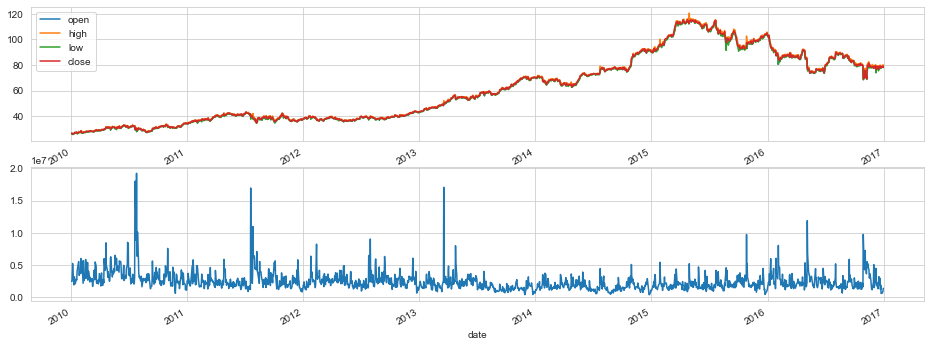

In [30]:
# plotting the OHLCV
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


ABC_df[['open','high','low','close']].plot(figsize=(16,6),ax=ax1)
ABC_df['volume'].plot(figsize=(16,6),ax=ax2)
fig.savefig('OHLCV.png')

In [31]:
# converting the dataframe to numpy array for later use.
dataset_array = ABC_df.to_numpy()

In [32]:
dataset_array.shape



(1762, 11)

In [33]:
# splitting the dataset into training set and testing set on a 80:20 basis.
dataset_train = np.array(dataset_array[:int(dataset_array.shape[0]*0.8),:])
dataset_test = np.array(dataset_array[int(dataset_array.shape[0]*0.8):,:])

In [34]:
dataset_train.shape

(1409, 11)

In [35]:
dataset_test.shape

(353, 11)

In [36]:
# feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(dataset_train)
testing_set_scaled = sc.fit_transform(dataset_test)

In [37]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
Y_train = []
for i in range(60, 1409):
    X_train.append(training_set_scaled[i-60:i, [0,2,3,6,7,8]])
    Y_train.append(training_set_scaled[i, 1])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)

# reshaping the training data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

In [38]:
X_train.shape

(1349, 60, 6)

In [39]:
# preparing the testing data for LSTM
X_test = []
for i in range(60, 353):
    X_test.append(testing_set_scaled[i-60:i, [0,2,3,6,7,8]])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [40]:
X_test.shape

(293, 60, 6)

In [41]:
# real Stock Price or Y_Test
Real_stock_price = dataset_test[60:,1]

In [42]:
Real_stock_price

array([ 97.669998,  97.470001,  97.889999,  97.610001,  97.400002,
        98.870003,  98.239998,  96.910004,  96.589996,  97.300003,
        99.169998, 100.309998,  99.190002,  99.099998,  98.730003,
        98.5     ,  98.93    ,  98.989998,  98.639999,  99.5     ,
        98.849998,  98.709999,  99.889999,  99.980003, 100.470001,
       100.669998, 101.949997, 102.080002, 102.529999, 101.690002,
       101.589996, 102.339996, 101.879997, 102.889999, 103.160004,
       103.940002, 103.949997, 104.190002, 104.769997, 105.019997,
       103.709999, 101.870003, 103.360001, 101.779999,  98.529999,
        97.959999,  94.059998,  94.18    ,  93.139999,  93.720001,
        92.769997,  92.540001,  90.900002,  90.57    ,  91.      ,
        91.269997,  91.260002,  90.18    ,  87.290001,  89.559998,
        89.      ,  88.139999,  87.989998,  84.400002,  84.699997,
        83.620003,  84.75    ,  85.599998,  84.550003,  85.610001,
        85.610001,  87.489998,  86.690002,  86.839996,  87.699

In [43]:
# initialising the RNN
regressor = Sequential()

In [44]:
# adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units = 1))

In [45]:
# compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the RNN to the Training set
regressor.fit(X_train, Y_train, epochs = 100, batch_size = 32)


Train on 1349 samples
Epoch 1/100
1349/1349 [==============================] - 38s 28ms/sample - loss: 0.0238
Epoch 2/100
1349/1349 [==============================] - 22s 17ms/sample - loss: 0.0038
Epoch 3/100
1349/1349 [==============================] - 23s 17ms/sample - loss: 0.0029
Epoch 4/100
1349/1349 [==============================] - 24s 18ms/sample - loss: 0.0032
Epoch 5/100
1349/1349 [==============================] - 23s 17ms/sample - loss: 0.0024
Epoch 6/100
1349/1349 [==============================] - 22s 16ms/sample - loss: 0.0020
Epoch 7/100
1349/1349 [==============================] - 22s 16ms/sample - loss: 0.0024
Epoch 8/100
1349/1349 [==============================] - 22s 17ms/sample - loss: 0.0018
Epoch 9/100
1349/1349 [==============================] - 22s 16ms/sample - loss: 0.0019
Epoch 10/100
1349/1349 [==============================] - 22s 17ms/sample - loss: 0.0020
Epoch 11/100
1349/1349 [==============================] - 23s 17ms/sample - loss: 0.0023
Epoch 12

1349/1349 [==============================] - 22s 16ms/sample - loss: 0.0010
Epoch 92/100
1349/1349 [==============================] - 22s 16ms/sample - loss: 7.6328e-04
Epoch 93/100
1349/1349 [==============================] - 22s 16ms/sample - loss: 7.9748e-04
Epoch 94/100
1349/1349 [==============================] - 22s 17ms/sample - loss: 8.3987e-04
Epoch 95/100
1349/1349 [==============================] - 22s 17ms/sample - loss: 8.5800e-04
Epoch 96/100
1349/1349 [==============================] - 22s 16ms/sample - loss: 0.0011
Epoch 97/100
1349/1349 [==============================] - 22s 17ms/sample - loss: 0.0010
Epoch 98/100
1349/1349 [==============================] - 22s 16ms/sample - loss: 7.3982e-04
Epoch 99/100
1349/1349 [==============================] - 22s 16ms/sample - loss: 7.6985e-04
Epoch 100/100
1349/1349 [==============================] - 22s 16ms/sample - loss: 7.9065e-04


In [46]:
# predicting the stock price
predicted_stock_price = regressor.predict(X_test)

In [47]:
# the length of the prediction is 293 instead of 353 as it uses the first 60 days to predict the 61st day and then a sliding window is created.
predicted_stock_price.shape


(293, 1)

In [49]:
# inversing the normalised predicted data.
trainPredict_dataset_like = np.zeros(shape=(len(predicted_stock_price), 11) )
trainPredict_dataset_like[:,1] = predicted_stock_price[:,0]
predicted_stock_price = sc.inverse_transform(trainPredict_dataset_like)[:,1]

In [50]:
trainPredict_dataset_like

array([[0.        , 0.73349708, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.74094748, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.74793494, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.23479687, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.23656444, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.23888025, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [51]:
predicted_stock_price

array([ 96.71951389,  97.00076656,  97.26454289,  97.51703509,
        97.74157686,  97.91390788,  98.11620316,  98.3385016 ,
        98.45815836,  98.45705807,  98.50961758,  98.78680886,
        99.2525317 ,  99.63103488,  99.85754996,  99.93608659,
        99.90662186,  99.88875851,  99.93990272, 100.02238823,
       100.20177549, 100.39200586, 100.53125177, 100.73336254,
       100.98340216, 101.28406398, 101.59300382, 101.8924146 ,
       102.15941304, 102.43485376, 102.62070548, 102.71284607,
       102.82896121, 102.9663193 , 103.19104783, 103.50284977,
       103.85139769, 104.18706843, 104.48174055, 104.73547704,
       104.95209405, 105.06925772, 104.99428746, 104.88548507,
       104.76295046, 104.5535562 , 104.28572073, 103.97002841,
       103.61257694, 103.20999346, 102.77813875, 102.30597169,
       101.77668647, 101.16610153, 100.46294173,  99.70752619,
        98.94319135,  98.18534572,  97.4111443 ,  96.59647302,
        95.81592639,  95.06703831,  94.31459287,  93.55

In [52]:
predicted_stock_price_df=pd.DataFrame(predicted_stock_price)
predicted_stock_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       293 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


In [53]:
Real_stock_price_df = pd.DataFrame(Real_stock_price)
Real_stock_price_df


,0
0,97.669998
1,97.470001
2,97.889999
3,97.610001
4,97.400002
...,...
288,78.559998
289,78.820000
290,78.349998
291,79.339996


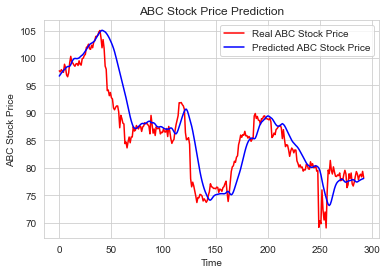

In [54]:
# plotting the predicted and real stock prices
plt.plot(Real_stock_price_df, color = 'red', label = 'Real ABC Stock Price')
plt.plot(predicted_stock_price_df, color = 'blue', label = 'Predicted ABC Stock Price')
plt.title('ABC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ABC Stock Price')
plt.legend()
plt.savefig('ABC Stock Price Prediction3.png')
plt.show()

In [55]:
# calculating the mse for our prediction.
mean_squared_error(Real_stock_price, predicted_stock_price)

13.919882386529688

In [56]:
#Calculate error and model accuracy with MAPE
total = 0
for i, j in zip(Real_stock_price, predicted_stock_price):
    value = abs(i - j) / abs(i)
    total += value
error = float(total*100/(len(Real_stock_price))) #calculate mape
mape = round(error, 1) #round to 3 significant figures
accuracy = 100 - mape #Calculate accuracy
print ("The LSTM's accuracy in predicting the stock price is: " + str(accuracy) + "%")

The LSTM's accuracy in predicting the stock price is: 97.0%
